# TP 4: Improve the Metropolis-Hastings algorithm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot
import pandas as pd

## Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

### 1.A – Metropolis-Hastings within Gibbs sampler

__Question 1:__ 

In [ ]:
def pi(z, a=10): 
    x, y = z
    return np.exp(-(x/a)**2 - y**2 - (((x/a)**2 - y**2)**2)/4)

In [ ]:
def MH_P1(x_previous, y_previous, sigma_x, a, nIter=1):
    acc = 0
    for i in range(nIter): 
        x_proposal = np.random.normal(loc=x_previous, scale=sigma_x)
        log_alpha = min(np.log(pi([x_proposal, y_previous], a)) - np.log(pi([x_previous, y_previous], a)), 0)
        u = np.random.uniform()
        if np.log(u) < log_alpha:
            x_previous = x_proposal
        acc += np.exp(log_alpha)
    acc /= nIter
    return np.array([x_previous, y_previous]), acc

def MH_P2(x_previous, y_previous, sigma_y, a, nIter=1):
    acc = 0
    for i in range(nIter):
        y_proposal = np.random.normal(loc=y_previous, scale=sigma_y)
        log_alpha = min(np.log(pi([x_previous, y_proposal], a)) - np.log(pi([x_previous, y_previous], a)), 0)
        u = np.random.uniform()
        if np.log(u) < log_alpha:
            y_previous = y_proposal
        acc += np.exp(log_alpha)
    acc /= nIter
    return np.array([x_previous, y_previous]), acc


def MH_P(N,x0,y0,a,sigma):
    sim = np.zeros((N,2))
    sim[0,:] = [x0, y0]
    acceptance_rate = [[],[]]
    for i in range(1,N):
        u = np.random.uniform()
        if u < 0.5:
          proposal, alpha_x = MH_P1(sim[i-1,0], sim[i-1,1], sigma[0], a)
          acceptance_rate[0].append(alpha_x)
        else:
          proposal, alpha_y = MH_P2(sim[i-1,0], sim[i-1,1], sigma[1], a)  
          acceptance_rate[1].append(alpha_y)

        sim[i,:] = proposal
    return sim, np.array(acceptance_rate)

### Question 2

We can see that our simulations focus around the center. We can see on the correlation plot that the chain has not converged since it oscillates instead of decreasing smoothly. The x acceptance rate is higher than the one of y. 

Therefore the algorithm doesn't perform well.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


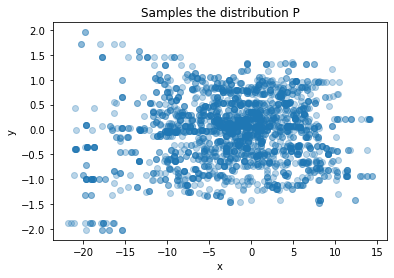

In [ ]:
N = 2500
simulation, acceptance = MH_P(N, 1, 0, a=10, sigma=[3,3])
plt.scatter(simulation[:,0], simulation[:,1], alpha=0.3)
plt.title("Samples the distribution P")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

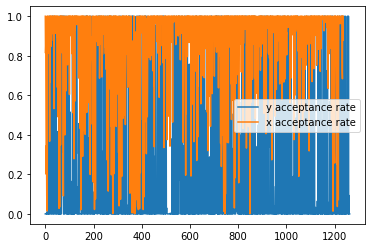

In [ ]:

plt.plot(np.arange(len(acceptance[1])), acceptance[1], label = "y acceptance rate")
plt.plot(np.arange(len(acceptance[0])), acceptance[0], label = "x acceptance rate")
plt.legend()
plt.show()

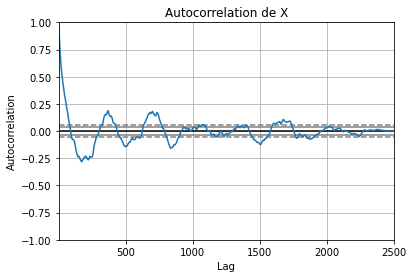

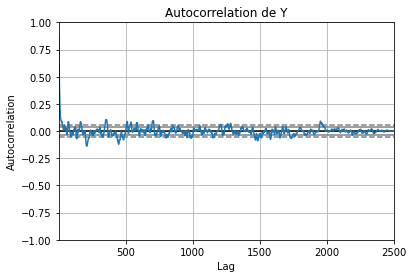

In [ ]:
dfx = pd.DataFrame(simulation[:,0], index=np.arange(0,N), columns=["Values"])
dfy = pd.DataFrame(simulation[:,1], index=np.arange(0,N), columns=["Values"])
autocorrelation_plot(dfx)
plt.title('Autocorrelation de X')
plt.show()
autocorrelation_plot(dfy)
plt.title('Autocorrelation de Y')
plt.show()

### 1.B – Adaptive Metropolis-Hastings within Gibbs sampler

__Question 1:__


The distance between acceptance rate is smaller than previously.
The algorithm with adaptation seems to converge faster. The auto-correlations plots converge faster and are a bit less noisy.

In [ ]:
def HM_adapted(init, distrib=pi, N=10, n_iter=2500, do_adaptation=True):
    d = init.shape[0]
    z = init
    l = np.zeros(d)

    samples = []
    list_acceptance = []
    list_l = [l]

    for k in range(n_iter):
        acceptance = np.zeros(d)
        for i in range(d):
            for _ in range(N):
                z_proposal = z.copy()
                z_proposal[i] = np.random.normal(size=1, loc=z[i], scale=np.exp(l[i]))
                log_alpha = np.log(distrib(z_proposal)) - np.log(distrib(z))
                acceptance[i] += min(np.exp(log_alpha), 1)
                u = np.random.rand()
                if np.log(u) < min(log_alpha, 0):
                    z = z_proposal
        acceptance /= N
        list_acceptance.append(acceptance)
        samples.append(z)

        if do_adaptation and (k+1)%50==0:
            l += min(0.01, 1/np.sqrt(k+1))*((acceptance > 0.24)*2 -1)
            list_l.append(l)
            
    return np.array(samples), (np.array(list_acceptance), np.array(list_l)) 

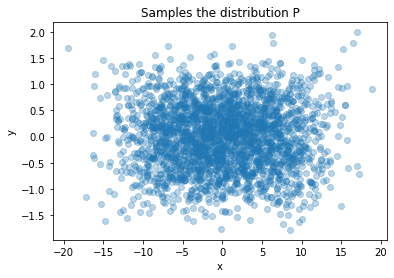

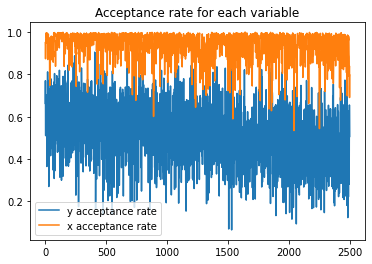

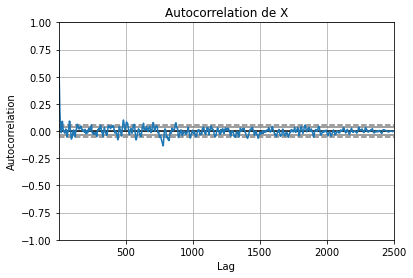

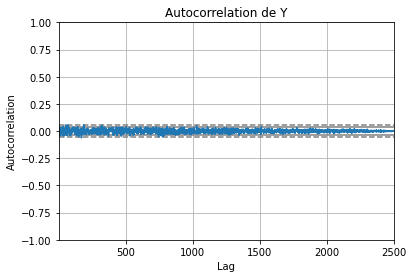

In [ ]:
# With adaptation
simulation, (acceptance, h_l) = HM_adapted(np.zeros(2))

plt.scatter(simulation[:, 0], simulation[:,1], alpha=0.3)
plt.title("Samples the distribution P")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(np.arange(len(acceptance[:,1])), acceptance[:,1], label = "y acceptance rate")
plt.plot(np.arange(len(acceptance[:,0])), acceptance[:,0], label = "x acceptance rate")
plt.legend()
plt.title('Acceptance rate for each variable')
plt.show()

dfx = pd.DataFrame(simulation[:,0], index=np.arange(0,len(simulation[:,0])), columns=["Values"])
dfy = pd.DataFrame(simulation[:,1], index=np.arange(0,len(simulation[:,1])), columns=["Values"])
autocorrelation_plot(dfx)
plt.title('Autocorrelation de X')
plt.show()
autocorrelation_plot(dfy)
plt.title('Autocorrelation de Y')
plt.show()


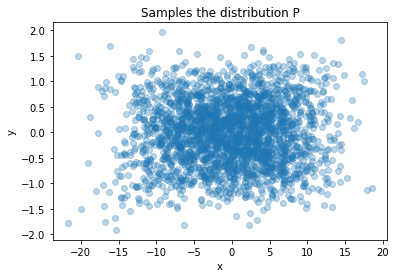

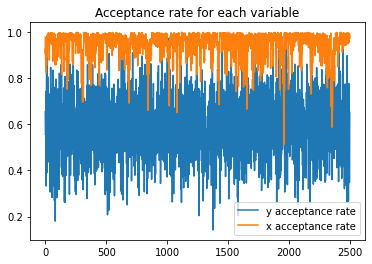

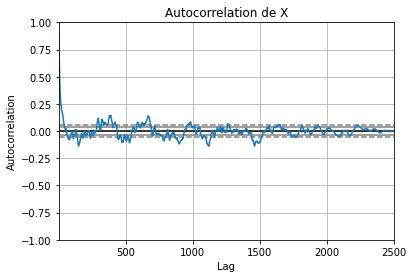

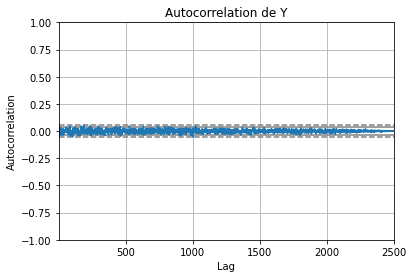

In [ ]:
# Without adaptation
simulation, (acceptance, h_l) = HM_adapted(np.zeros(2), do_adaptation=False)

plt.scatter(simulation[:, 0], simulation[:,1], alpha=0.3)
plt.title("Samples the distribution P")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(np.arange(len(acceptance[:,1])), acceptance[:,1], label = "y acceptance rate")
plt.plot(np.arange(len(acceptance[:,0])), acceptance[:,0], label = "x acceptance rate")
plt.legend()
plt.title('Acceptance rate for each variable')
plt.show()

dfx = pd.DataFrame(simulation[:,0], index=np.arange(0,len(simulation[:,0])), columns=["Values"])
dfy = pd.DataFrame(simulation[:,1], index=np.arange(0,len(simulation[:,1])), columns=["Values"])
autocorrelation_plot(dfx)
plt.title('Autocorrelation de X')
plt.show()
autocorrelation_plot(dfy)
plt.title('Autocorrelation de Y')
plt.show()


__Question 2:__

In [ ]:
def pi_banana(z):
    B = 0.1
    return np.exp(-z[0]**2/200 - 0.5*(z[1]+B*z[0]**2- 100*B)**2 -0.5*np.sum(z[2:]**2))
    

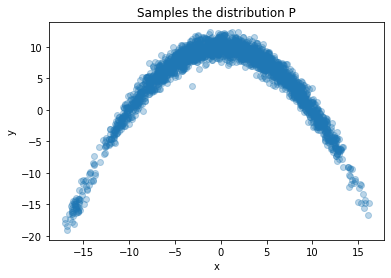

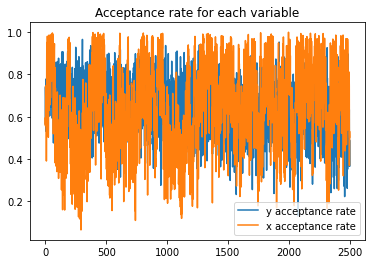

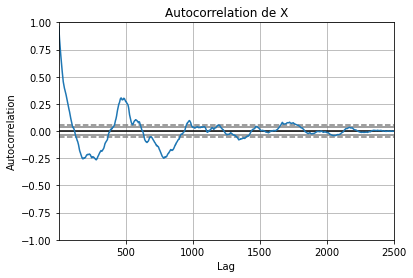

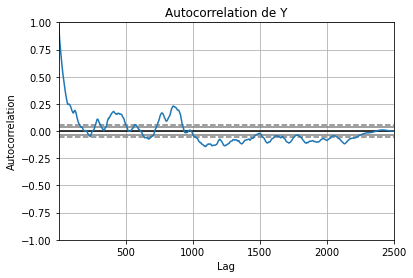

In [ ]:
# Banana with adaptation
simulation, (acceptance, h_l) = HM_adapted(np.zeros(20), distrib=pi_banana)


plt.scatter(simulation[:, 0], simulation[:,1], alpha=0.3)
plt.title("Samples the distribution P")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(np.arange(len(acceptance[:,1])), acceptance[:,1], label = "y acceptance rate")
plt.plot(np.arange(len(acceptance[:,0])), acceptance[:,0], label = "x acceptance rate")
plt.legend()
plt.title('Acceptance rate for each variable')
plt.show()

dfx = pd.DataFrame(simulation[:,0], index=np.arange(0,len(simulation[:,0])), columns=["Values"])
dfy = pd.DataFrame(simulation[:,1], index=np.arange(0,len(simulation[:,1])), columns=["Values"])
autocorrelation_plot(dfx)
plt.title('Autocorrelation de X')
plt.show()
autocorrelation_plot(dfy)
plt.title('Autocorrelation de Y')
plt.show()



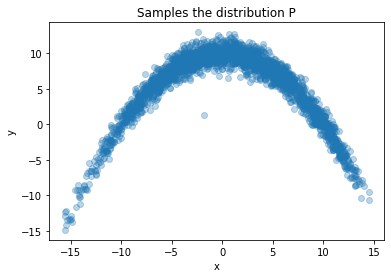

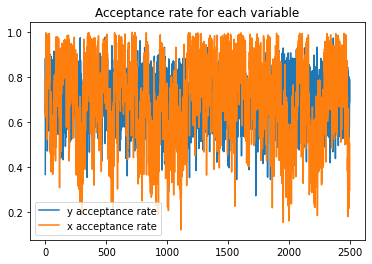

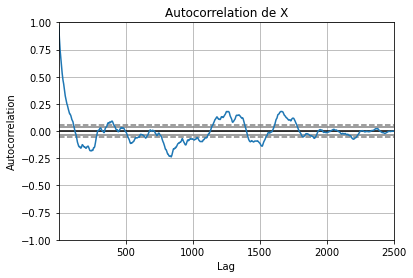

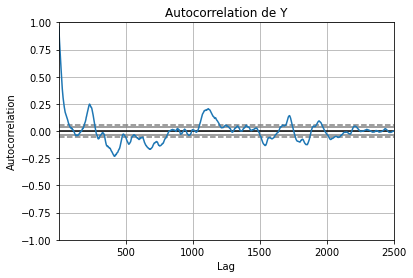

In [ ]:
# Banana without adaptation
simulation, (acceptance, h_l) = HM_adapted(np.zeros(2), distrib=pi_banana, do_adaptation = False)

plt.scatter(simulation[:, 0], simulation[:,1], alpha=0.3)
plt.title("Samples the distribution P")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(np.arange(len(acceptance[:,1])), acceptance[:,1], label = "y acceptance rate")
plt.plot(np.arange(len(acceptance[:,0])), acceptance[:,0], label = "x acceptance rate")
plt.legend()
plt.title('Acceptance rate for each variable')
plt.show()

dfx = pd.DataFrame(simulation[:,0], index=np.arange(0,len(simulation[:,0])), columns=["Values"])
dfy = pd.DataFrame(simulation[:,1], index=np.arange(0,len(simulation[:,1])), columns=["Values"])
autocorrelation_plot(dfx)
plt.title('Autocorrelation de X')
plt.show()
autocorrelation_plot(dfy)
plt.title('Autocorrelation de Y')
plt.show()



## Exercise 2: Sampling from multimodal distributions

### 2.A – A toy example

In [ ]:
from scipy.stats import multivariate_normal

def pi_mixture(z, list_mu):
    sum = 0
    for m in list_mu:
        m = np.array(m, dtype=object)
        sum += multivariate_normal.pdf(z, m, 0.1**2)
    return 0.05 * sum

def HM_sym_x(x0,y0,distrib,mu,sigma=1):
    x_proposal = np.random.normal(loc=x0, scale=sigma)
    alpha = min(1, distrib(np.array([x_proposal,y0]),mu)/distrib(np.array([x0,y0]),mu))
    if (np.random.rand()<alpha):
        return x_proposal, alpha
    else:
        return x0, alpha
    
def HM_sym_y(x0,y0,distrib,mu,sigma=1):
    y_proposal = np.random.normal(loc=y0, scale=sigma)
    alpha = min(1,distrib(np.array([x0,y_proposal]),mu) / distrib(np.array([x0,y0]),mu))
    if (np.random.rand()<alpha):
        return y_proposal, alpha
    else:
        return y0, alpha

def HM_sym(N,x0,y0,distrib,mu):
    sim = np.zeros((N+1,2))
    sim[0,:] = [x0,y0]
    acceptance_x = []
    acceptance_y = []
    for i in range(N):
        x, alpha_x = HM_sym_x(sim[i,0],sim[i,1],distrib,mu)
        sim[i+1,0] = x
        acceptance_x.append(alpha_x)

        y, alpha_y = HM_sym_y(sim[i+1,0],sim[i,1],distrib,mu)
        sim[i+1,1] = y
        acceptance_y.append(alpha_y)
    return sim, np.array([acceptance_x, acceptance_y])

__Question 2:__

The algorithm fail to sample from the distribution as we can see ofn the following plot. ALl samples are stuck around some means, while it looks like some means have not been sampled at all. 

In moreover, we can see that the algorithm has not converged given the oscillations on the autocorrelation plot. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


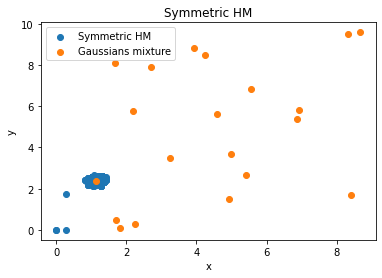

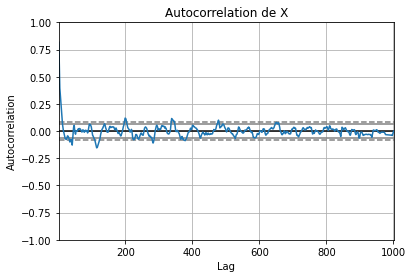

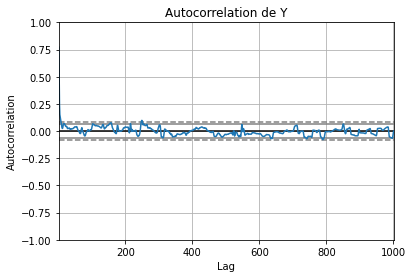

In [ ]:


mu = np.array([[2.18, 5.76],[8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82], [3.25, 3.47], [1.7, 0.5], [4.59, 5.6], [6.91, 5.81], [6.87, 5.4], [
			5.41, 2.65], [2.7, 7.88], [4.98, 3.7], [1.14, 2.39], [8.33, 9.5], [4.93, 1.5], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]])

simulation, acceptance = HM_sym(1000,0,0,pi_mixture,mu)



fig = plt.figure()
plt.title("Symmetric HM")
ax = fig.add_subplot(111)
scatter = ax.scatter(simulation[:,0],simulation[:,1], label='Symmetric HM')
scatter = ax.scatter(mu[:,0],mu[:,1],label='Gaussians mixture')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

dfx = pd.DataFrame(simulation[:,0], index=np.arange(0,len(simulation[:,0])), columns=["Values"])
dfy = pd.DataFrame(simulation[:,1], index=np.arange(0,len(simulation[:,1])), columns=["Values"])
autocorrelation_plot(dfx)
plt.title('Autocorrelation de X')
plt.show()
autocorrelation_plot(dfy)
plt.title('Autocorrelation de Y')
plt.show()

### 2.B – Parallel Tempering

In [ ]:
def parallel_tempering_x(x0,y0,distrib,list_mu,t,sigma=1):
    x_proposal = np.random.normal(loc=x0, scale=sigma)
    alpha = min(0,np.log(distrib(np.array([x_proposal,y0]),list_mu))*(1./(1.*t)) - np.log(distrib(np.array([x0,y0]),list_mu))*(1./(1.*t)))
    if (np.log(np.random.rand())<alpha):
        return x_proposal, alpha
    else:
        return x0, alpha

def parallel_tempering_y(x0,y0,distrib,list_mu,t,sigma=1):
    y_proposal = np.random.normal(loc=y0, scale=sigma)
    alpha = min(0,np.log(distrib(np.array([x0,y_proposal]),list_mu))*(1./(1.*t)) - np.log(distrib(np.array([x0,y0]),list_mu))*(1./(1.*t)))
    if (np.log(np.random.rand())<alpha):
        return y_proposal, alpha
    else:
        return y0, alpha


def parallel_tempering(T,N,distrib,list_mu):
    sim = np.zeros((len(T),2,N+1))
    for n in range(N):
        for t in range(len(T)):
            sim[t,0,n+1], _ = parallel_tempering_x(sim[t,0,n],sim[t,1,n],distrib,list_mu,T[t],sigma=0.25*np.sqrt(T[t]))
            sim[t,1,n+1], _ = parallel_tempering_y(sim[t,0,n+1],sim[t,1,n],distrib,list_mu,T[t],sigma=0.25*np.sqrt(T[t]))

        i = np.random.randint(0,len(T))
        j = np.random.choice(np.delete(np.arange(len(T)),i))

        alpha = (distrib(sim[i,:,n+1],list_mu)**(1/T[j]) * distrib(sim[j,:,n+1],list_mu)**(1./(1.*T[i]))) / (distrib(sim[j,:,n+1],list_mu)**(1./(1.*T[j])) * distrib(sim[i,:,n+1],list_mu)**(1./(1.*T[i])))
        alpha = min(1,alpha)

        u = np.random.rand()
        if u < alpha:
            save0 = sim[i,0,n+1]
            save1 = sim[i,1,n+1]
            sim[i,0,n+1] = sim[j,0,n+1]
            sim[i,1,n+1] = sim[j,1,n+1]
            sim[j,0,n+1] = save0
            sim[j,1,n+1] = save1
    return sim

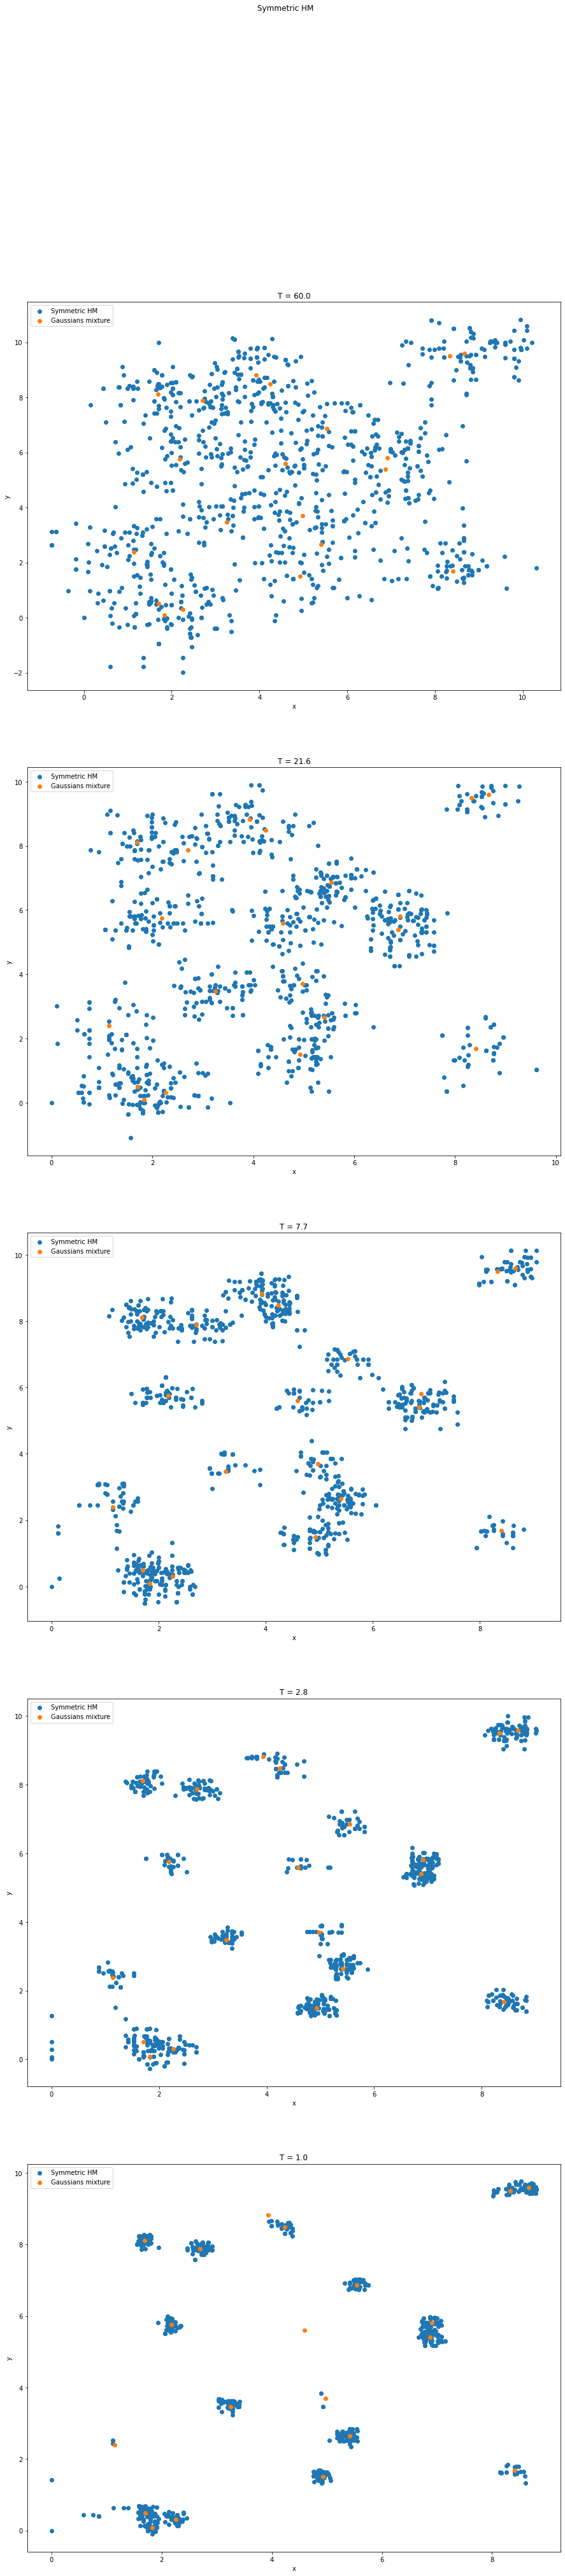

In [ ]:
T = np.array([60,21.6,7.7,2.8,1])

#simulation = parallel_tempering(T,1000,pi_mixture,mu)

fig = plt.figure(figsize=(15,65))
plt.suptitle("Symmetric HM")
for i in range(5):
  ax = fig.add_subplot('51'+str(i+1))
  scatter = ax.scatter(simulation[i,0,:],simulation[i,1,:], label='Symmetric HM')
  scatter = ax.scatter(mu[:,0],mu[:,1],label='Gaussians mixture')
  plt.title("T = "+str(T[i]))
  ax.legend()
  ax.set_xlabel('x')
  ax.set_ylabel('y')
plt.show()

## Exercise 3: Bayesian analysis of a one-way random effects model



__Question 1:__


Let's compute the conditionnal distribution, 
$$
\begin{align*}
P(Y|X, \mu,\sigma^2,\tau^2) &\propto P(\epsilon |X, \mu,\sigma^2,\tau^2)\\
& \propto (\frac{1}{\tau})^{N} exp(- \frac{\sum_{i=0}^N \sum_{j=0}^{k_i} (Y_{i,j} - X_i)^2}{2\tau^2})\\
\end{align*}
$$

Then, 
$$
\begin{align*}
P(X, \mu,\sigma^2,\tau^2|Y) & \propto P(Y|X, \mu,\sigma^2,\tau^2) P(X, \mu,\sigma^2,\tau^2)\\
& \propto P(Y|X, \mu,\sigma^2,\tau^2) P(X| \mu, \sigma^2, \tau^2) \pi_{prior}(\mu,\sigma^2,\tau^2)\\
& \propto (\frac{1}{\tau})^{N}  exp(- \frac{\sum_{i=0}^N \sum_{j=0}^{k_i} (Y_{i,j} - X_i)^2}{2\tau^2}) * (\frac{1}{\sigma})^{N} exp(- \frac{\sum_{i=0}^N (X_i - \mu)^2}{2\sigma^2}) * \frac{1}{\sigma^{2(1+\alpha)}} exp(-\frac{\beta}{\sigma^2}) \frac{1}{\tau^{2(1+\gamma)}}exp(-\frac{\beta}{\tau^2})\\
& \propto \frac{1}{\tau^2}^{N/2 +1+\gamma}\frac{1}{\sigma^2}^{N/2 +1+\alpha} exp(- \frac{\sum_{i=0}^N \sum_{j=0}^{k_i} (Y_{i,j} - X_i)^2}{2\tau^2} - \frac{\sum_{i=0}^N (X_i - \mu)^2}{2\sigma^2}-\frac{\beta}{\sigma^2}-\frac{\beta}{\tau^2})\\
\end{align*}
$$


__Question 2:__

We deduce that 
$$
\begin{align*}
P(X| \mu,\sigma^2,\tau^2, Y)& \propto exp(- \frac{\sum_{i=0}^N \sum_{j=0}^{k_i} (Y_{i,j} - X_i)^2}{2\tau^2} - \frac{\sum_{i=0}^N (X_i - \mu)^2}{2\sigma^2})\\
P(\mu |X, \sigma^2,\tau^2, Y)& \propto exp( - \frac{\sum_{i=0}^N (X_i - \mu)^2}{2\sigma^2})\\
P(\sigma^2 |X, \mu,\tau^2, Y)& \propto \frac{1}{\sigma^2}^{N/2 +1+\alpha} exp(- \frac{\sum_{i=0}^N (X_i - \mu)^2}{2\sigma^2}-\frac{\beta}{\sigma^2}) \\
P(\tau^2 |X, \mu,\sigma^2, Y)& \propto \frac{1}{\tau^2}^{N/2 +1+\gamma} exp(- \frac{\sum_{i=0}^N \sum_{j=0}^{k_i} (Y_{i,j} - X_i)^2}{2\tau^2} -\frac{\beta}{\tau^2})
\end{align*} \\
$$

Therefore $\forall i \in {1,...N}, X_i \sim \mathcal{N}(\frac{\tau^2\mu+\sigma^2\sum_{j=1}^{k_i}y_{i,j}}{k_i\sigma^2 + \tau ^2}, \frac{\sigma^2\tau^2}{k_i\sigma^2+\tau^2})$

$\mu \sim \mathcal{N}(\frac{\sum_{i=1}^N X_i}{N}, \frac{\sigma^2}{N})$

$\sigma \sim \mathcal{G}(N/2 + \alpha, \frac{\sum_{i=0}^N (X_i-\mu)^2}{2}+\beta)$

$\tau \sim \mathcal{G}(N/2 + \gamma, \frac{\sum_{i=0}^N \sum_{j=1}^{k_i}(y_{i,j}-X_i)^2}{2}+\beta)$


In [41]:
def Gibs(Y, sigma_0, tau_0, mu_0, x_0, alpha, beta, gamma, nIter):
    sigma = sigma_0
    tau = tau_0
    mu = mu_0
    x = x_0
    N, k = Y.shape
    
    list_sigma = []
    list_tau = []
    list_mu = []
    list_x = []
    
    for i in range(nIter):
        tau = 1./np.random.gamma(shape=((1.*k*N)/2.+gamma),scale=1./(beta+np.sum((Y.T-x)**2)/2.),size=1)
        sigma = 1./np.random.gamma(shape=((1.*N)/2.+alpha),scale=1./(beta+np.sum((x-mu)**2)/2.),size=1)
        mu = np.random.normal(loc=np.mean(x),scale=np.sqrt(sigma/(1.*k)),size=1)
        for j in range(N):
            x[j] = np.random.normal((tau*mu+sigma*np.sum(Y[j,:]))/(k*sigma+tau),scale=np.sqrt((sigma*tau)/(k*sigma+tau)),size=1)
        
        list_sigma.append(sigma)
        list_tau.append(tau)
        list_mu.append(mu)
        list_x.append(x)
        
    return list_sigma, list_tau, list_mu, list_x

__Question 4__: 

The Block-Gibbs sampler is supposed to converge faster in terms of number of iteration. But it also needs more computationnal time and memory.
The block-Gibbs sampler is only usefull if the number of dimension is low.



__Question 5:__

In [42]:
def generate_data(mu, sigma, tau, N, k):
    """Generate a dataset as described in exercice, all k_i = k"""
    Y = np.zeros((N,k))
    for i in range(N):
        X = np.random.normal(loc=mu,scale=np.sqrt(sigma),size=1)
        epsilon = np.random.normal(loc=0.,scale=np.sqrt(tau),size=k)
        Y[i,:] = X + epsilon
    return(Y)


mu = 2
sigma = 0.2
N = 1000
tau = 0.005
k = 5

Y_data = generate_data(mu,sigma,tau,N,k)

In [43]:
alpha = 0.05
beta = 0.01
gamma = 0.02
sigma_0 = 2.
tau_0 = 1.
mu_0 = 1.
x_0 = np.zeros(N)

sigma, tau, mu, x = Gibs(Y_data, sigma_0, tau_0, mu_0, x_0, alpha, beta, gamma, nIter=2500)

Text(0.5, 1.0, 'Histogram of tau')

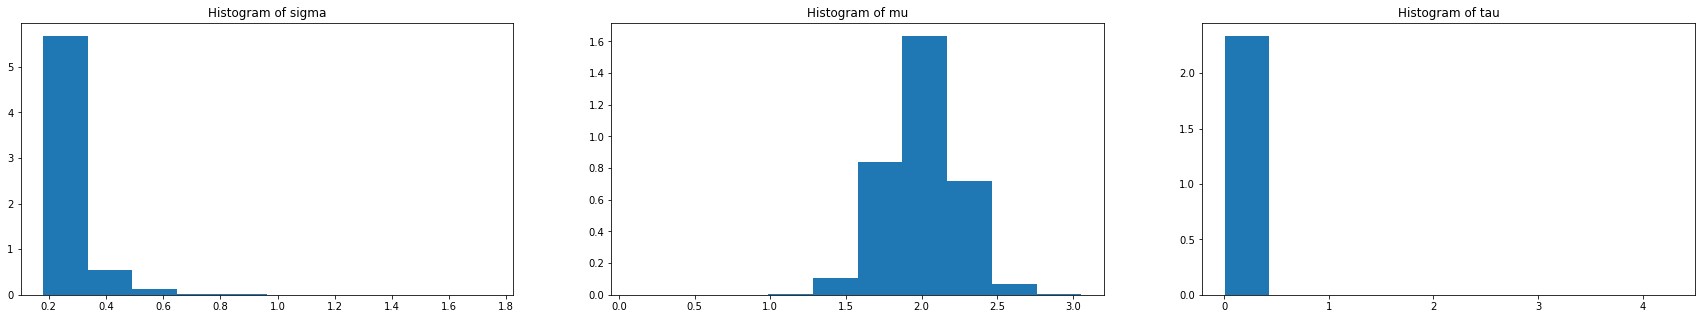

In [44]:


fig= plt.figure(figsize=(30,5))

plt.subplot(131)
plt.hist(np.array(sigma),density=True)
plt.title('Histogram of sigma')

plt.subplot(132)
plt.hist(np.array(mu),density=True)
plt.title('Histogram of mu')

plt.subplot(133)
plt.hist(np.array(tau),density=True)
plt.title('Histogram of tau')



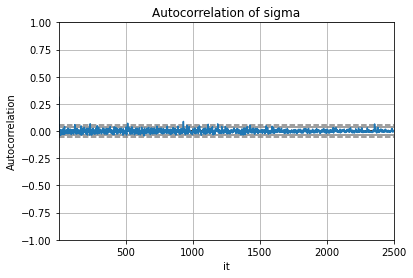

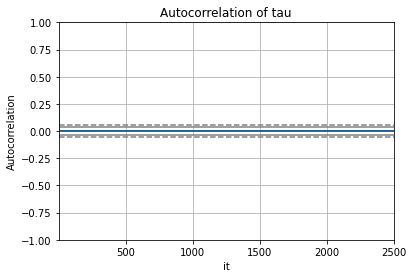

Text(0, 0.5, 'Autocorrelation')

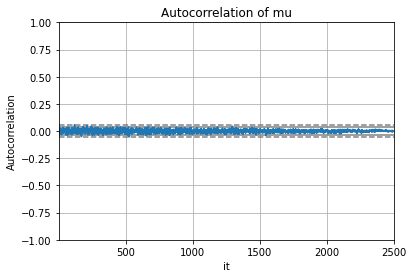

In [45]:

df = pd.DataFrame(sigma, index=np.arange(len(sigma)), columns=["Values"])
autocorrelation_plot(df)  
plt.title('Autocorrelation of sigma')
plt.xlabel('it')
plt.ylabel('Autocorrelation')
plt.show()

df = pd.DataFrame(tau, index=np.arange(len(tau)), columns=["Values"])
autocorrelation_plot(df)  
plt.title('Autocorrelation of tau')
plt.xlabel('it')
plt.ylabel('Autocorrelation')
plt.show()

df = pd.DataFrame(mu, index=np.arange(len(mu)), columns=["Values"])
autocorrelation_plot(df)  
plt.title('Autocorrelation of mu')
plt.xlabel('it')
plt.ylabel('Autocorrelation')

